# Ventilation Parameters

The following example demonstrates how to work with Ventilation measurements represented in `*_Ventilation*.csv`.

We utilize `pandas` for representation of data tables and `matplotlib` for visualization of data.

In [1]:
import os, pandas, matplotlib, numpy
import matplotlib.pyplot as plt

First, we download an example file from the `lapdMouse` data archive using the `lapdMouseUtils` module which is part of the [lapdMousePythonExamples](https://github.com/lapdMouse/lapdMousePythonExamples). We can then load the `.csv` file with `pandas`

In [2]:
from lapdMouseUtils import DBUtil
DBUtil().downloadFile('m01/m01_Ventilation_Pre.csv')
df = pandas.read_csv('m01/m01_Ventilation_Pre.csv')
df.head(10)

,time,Flow,RR,Inspiration
0,4.62,3.739,180,1
1,4.63,35.119,180,1
2,4.64,58.149,180,1
3,4.65,68.478,180,1
4,4.66,72.454,180,1
5,4.67,76.099,180,1
6,4.68,80.865,180,1
7,4.69,84.667,180,1
8,4.70,88.241,180,1
9,4.71,91.639,180,1


  * The files have 4 columns: **time**, **Flow**, **respiratory rate (RR)**, and **inspiration**.
  * The flow sensor only measures inspiration (voltage>0; inspiration=1). Expiration is shown as inspiration=0, but the reported flow values during these ranges are meaningless.
  * Respiratory rate reported by the data acquisition system is given in the RR column.

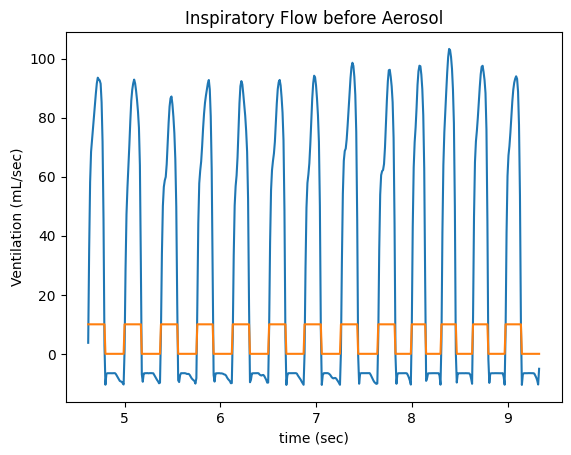

In [3]:
plt.figure()
plt.plot(df['time'], df['Flow'])
plt.plot(df['time'], df['Inspiration']*10)
plt.xlabel('time (sec)')
plt.ylabel('Ventilation (mL/sec)')
plt.title('Inspiratory Flow before Aerosol');

## Estimate Respiratory Rate and I:E Ratio

Respiratory rate (RR) is reported by the data acquisition system as a rolling average over several breaths. You can also determine the average RR from the breaths.

In [4]:
inspire = numpy.asarray(df['Inspiration'])
transitions = numpy.asarray(numpy.logical_xor(inspire[1:-1],inspire[2:]))
transitions = numpy.insert(transitions, 0, True, axis=0) # First transition occurs at first point
iTrans = numpy.asmatrix(transitions.nonzero()) # Marks transitions between I and E
jTrans = iTrans.reshape(-1,2) # Split into I locations in 1st column and E in 2nd
nBreaths = jTrans.shape[0]
print("nBreaths = %d" % (nBreaths))

nBreaths = 13


In [5]:
RR = nBreaths * 60 / (df['time'].iloc[-1] - df['time'].iloc[0])
print("RR = %d bpm" % (round(RR)))

RR = 166 bpm


In [6]:
IE = sum(df['Inspiration']) / sum(numpy.logical_not(df['Inspiration']))
print("I:E = %.2f" % (IE))

I:E = 0.91


## Estimate average tidal volume

This could be fine-tuned by using trapezoidal rule for the integration of flow vs time, we will short-circuit this by summing the flows during the inspiratory phases.

In [7]:
VTavg = 0
dt = df['time'][1] - df['time'][0]
for oneBreath in jTrans:
    iStart = oneBreath[0,0]
    iEnd = oneBreath[0,1]
    VT = sum(df['Flow'][iStart:iEnd]) * dt / 60
    VTavg = VTavg + VT

VTavg = VTavg / nBreaths
print("VT = %.2f mL" % (VTavg))

VT = 0.19 mL
